# Chapter 9
# 비지도 학습

# 9.1 2차원 입력 데이터

비지도 학습 문제는 클레스 데이터를 사용하지 않는다.

클래스 정보없이, 입력데이터가 비슷한 것끼리 클래스로 나누는것이 클러스터링이다

데이터 분포에서 클러스터를 찾아, 동일한 클러스터에 속하는 데이터 점에는 같은 클래스(라벨)을 붙이고, 다른 클러스터에 속하는 데이터 점에는 다른 클래스를 할당하는것이 클러스터링이다

클래스
- 단순한 라벨

클러스터
- 분포의 특징을 나타낸다

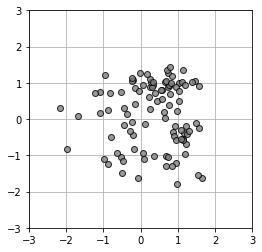

In [1]:
# ----------------- 리스트 9-1-(1)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터 생성 --------------------------------
np.random.seed(1)
N = 100
K = 3
T3 = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ['cornflowerblue', 'black', 'white']
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 누적 확률
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k]
                   + Mu[T3[n, :] == 1, k])


# 데이터를 그리기 ------------------------------
def show_data(x):
    plt.plot(x[:, 0], x[:, 1], linestyle='none',
             marker='o', markersize=6,
             markeredgecolor='black', color='gray', alpha=0.8)
    plt.grid(True)


# 메인 ------------------------------------
plt.figure(1, figsize=(4, 4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez('data_ch9.npz', X=X, X_range0=X_range0,
         X_range1=X_range1)


# 9.2 K-means 기법

## 9.2.1 K-means 기법의 개요

$\mu$ : 클러스터의 중심벡터

R  : 각 데이터의 클래스 지시 변수

>step 0 : $\mu$의 초기값을 부여한다, 분할할 클러스터의 수 K를 결정한다
>
>step 1 : $\mu$로 R 을 갱신, 각 데이터 점을 가장 중심이 가까운 클러스터에 소속시킨다
>
>step 2 : R로 $\mu$를 갱신 각 클러스터에 속하는 데이터 점의 중심을 새로운 $\mu$로한다
>
>step 3 : step1 과 step2 를 값이 변화하지 않을때까지 반복한다

## 9.2.2 Step 0: 변수의 준비와 초기화

#### $\mu$ 의 초기화

입력차원의 K개의 임의로 초기화된 중심벡터를 생성한다

#### R의 초기화
각 데이터가 어느 클래스에 속해 있는지를  1-of-k 부호화법으로 나타낸다. 

첫 초기화시에는 랜덤 혹은 0번째 클래스에 속하도록 R을 초기화 한다

In [2]:
# ----------------- 리스트 9-1-(2)
# Mu 및 R 초기화 -----------------------------
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) # (A)
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] # (B)

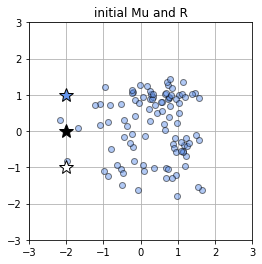

In [3]:
# ----------------- 리스트 9-1-(3)
# 데이터를 그리는 함수 ---------------------------
def show_prm(x, r, mu, col):
    for k in range(K):
        # 데이터 분포의 묘사
        plt.plot(x[r[:, k] == 1, 0], x[r[:, k] == 1, 1],
                 marker='o',
                 markerfacecolor=X_col[k], markeredgecolor='k',
                 markersize=6, alpha=0.5, linestyle='none')
        # 데이터의 평균을 "별표"로 묘사
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=X_col[k], markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    plt.grid(True)


# ------------------------------
plt.figure(figsize=(4, 4))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

## 9.2.3 Step 1 : R의 갱신

#### R의 갱신

- 각 데이터 점을 가장 중심이 가까운 클러스터에 넣는다

각각의 데이터 점에서 클러스터 중심까지의 제곱거리를 구해서 비교한다.

계산한 제곱거리를 비교하여 가장 가까운 클러스터의 중심점으로 데이터점의 클러스터를 결정한다

결정한 클러스터는 1-of-k 부호화법으로 표시한다

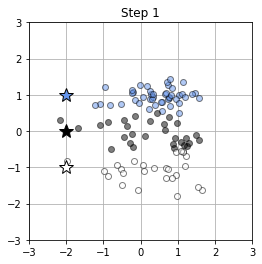

In [4]:
# ----------------- 리스트 9-1-(4)
# r을 결정한다 (Step 1) -----------
def step1_kmeans(x0, x1, mu):
    N = len(x0)
    r = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = (x0[n] - mu[k, 0])**2 + (x1[n] - mu[k, 1])**2
        r[n, np.argmin(wk)] = 1
    return r


# ------------------------------
plt.figure(figsize=(4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

## 9.2.3 Step 2 : $\mu$의 갱신

#### $\mu$의 갱신

- 각 클러스터에 속하는 데이터 점의 중심을 새로운 $\mu$로 한다

같은 클러스터(1-of-k 부호화법으로 표시된 R의 라벨) 의 데이터 점들의 평균을 구하여 중심점을 구한다

$\mu_k$의 위치를 각각 분포의 중심점으로 이동한다

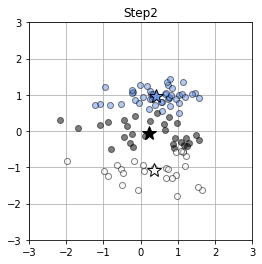

In [5]:
# ----------------- 리스트 9-1-(5)
# Mu 결정 (Step 2) ----------
def step2_kmeans(x0, x1, r):
    mu = np.zeros((K, 2))
    for k in range(K):
        mu[k, 0] = np.sum(r[:, k] * x0) / np.sum(r[:, k])
        mu[k, 1] = np.sum(r[:, k] * x1) / np.sum(r[:, k])
    return mu


# ------------------------------
plt.figure(figsize=(4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step2')
plt.show()

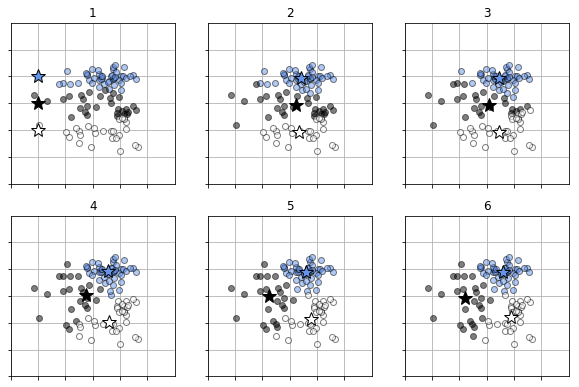

In [6]:
# ----------------- 리스트 9-1-(6)
plt.figure(1, figsize=(10, 6.5))
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
max_it = 6 # 반복 횟수
for it in range(0, max_it):
    plt.subplot(2, 3, it + 1)
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    show_prm(X, R, Mu, X_col)
    plt.title("{0:d}".format(it + 1))
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "")
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
plt.show()

## 9.2.5 왜곡 척도

k-means 기법의 경우, 데이터 점이 속한 클러스터의 중심까지의 제곱거리를 전체 데이터로 합한것이 목적함수에 대응한다

이를 왜곡척도 (distorition measure) 라고 한다

$$J = \sum_{n\ in\ cluster\ 0} |x_n-\mu_0|^2 + \sum_{n\ in\ cluster\ 1} |x_n-\mu_1|^2 + \sum_{n\ in\ cluster\ 2} |x_n-\mu_2|^2 + $$

$$J = \sum_{k=0}^{2}\sum_{n\ in\ cluster\ k} |x_n-\mu_k|^2$$

$r_{nk}$는 n이 속한 클러스터 에서만 1, 속하지 않는 클러스터에서는 0이 되는 변수임으로

$$J = \sum_{n=0}^{N-1}\sum_{k=0} r_{nk} |x_n-\mu_k|^2$$

으로 표현 가능하다

---

k-means 기법으로 얻을 수 있는 해는 초기값 으존성이 있다.

처음 $\mu$에 무엇을 할당하는 지에 따라 결과가 달라질 수 있다

다양한 $\mu$에서 시작하여 얻은결과 중 가장 왜곡척도가 작은 결과를 사용한다

---

예제에서는 $\mu$ 를 먼저 정했지만 R을 먼저 결정해도 괜찮다. 이 경우 R을 임의로 정해 거기서 $\mu$를 찾아가는 절차가 된다

In [7]:
# ----------------- 리스트 9-1-(7)
# 목적 함수 ----------------------------------
def distortion_measure(x0, x1, r, mu):
    # 입력은 2차원으로 제한하고 있다
    N = len(x0)
    J = 0
    for n in range(N):
        for k in range(K):
            J = J + r[n, k] * ((x0[n] - mu[k, 0])**2
                               + (x1[n] - mu[k, 1])**2)
    return J


# ---- test
# ---- Mu와 R의 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
distortion_measure(X[:, 0], X[:, 1], R, Mu)

771.7091170334878

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


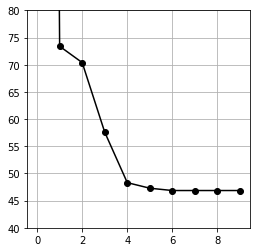

In [8]:
# ----------------- 리스트 9-1-(8)
# Mu와 R의 초기화
N=X.shape[0]
K=3
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
max_it = 10
it = 0
DM = np.zeros(max_it) # 왜곡 척도의 계산 결과를 넣는다
for it in range(0, max_it): # K-means 법
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu) # 왜곡 척도
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
print(np.round(DM, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(DM, color='black', linestyle='-', marker='o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

# 9.3 가우시안 혼합 모델

## 9.3.1 확률적 클러스터링

#### 확률의 개념을 도입한 k-means 기법으로 다룬 R의 확장

클러스터 0과 클러스터 1 에 모두 속해있는 모호성을 포함해 수치화하는 경우 확률의 개념을 도입한다

1-of-k 부호화법 대신 라벨을 속할 확률 $\gamma$ 로 표현한다

3개의 확률을 더하면 1이된다.

---

#### 클러스터에 속할 확률

각 데이터에 대하여 어떤 클러스터에 속할지에 대한 확률(사후확률)을 $\gamma$로 생각한다.

이것이 클러스터에 속해 있을 가능성을 의미한다

---

관찰하지는 못했지만 데이터에 영향을 준 변수를 잠재변수(hidden variable)이라고 한다

이 hiddn variable을 1-of-K 부호화법으로 표현할 수 있다


---

잠재변수를 데이터의 행렬로 표기할때는 Z 로 표기한다

이 관점에서 데이터 n 이 클러스터 k에 속할 확률$\gamma_{nk}$는 데이터 xn인 객체가 클래스k 일 확률을 의미한다

$$\gamma_{nk} = P(z_{nk}=1|x_n)$$

즉, 관찰할 수 없는 Z의 추정치가 $\gamma$이다

Z는 어떤 클래스에 속하는가 라는 사실임으로 0 또는 1의 값을 갖지만

$\gamma$는 확률적인 추정값이므로 0에서 1사이의 실수값을 취한다

$\gamma$는 어떤 클러스터에 얼마나 기여하고 있는가 라는 의미애서 부담률(responsibility)라고 한다

---

확률적 클러스터링은 데이터의 배후에 숨어있는 잠재변수 Z를 확률적으로 $\gamma$로 추정하는 것이다

## 9.3.2 가우시안 혼합모델

부담률 $\gamma$를 구하기 위해 가우시안 혼합모델을 사용한다.

---

가우시안 혼합 모델은 K개의 가우스 분포를 모두 합해 다양한 분포를 표현할 수 있다.

$$p(x) = \sum_{k=0}^{k-1} \pi_k N (x|\mu_k,\sigma_{k})$$

$\mu_k$ : 중심벡터 , 각 가우스 분포 k의 중심

$\sigma_{k}$ : 공분산 행렬 , 각 가우스 분포 k 의 퍼짐

$\pi_k$ : 혼합계수 , 각각의 가우스 분포의 크기의 비율
- 혼합계수는 0과 1 사이의 실수로, K로 합을 취했을때 1이 되어야 한다
-$\sum_{k=0}^{k-1} \pi_k = 1 $

In [9]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [10]:
# ----------------- 리스트 9-2-(1)
import numpy as np
wk = np.load('data_ch9.npz')
X = wk['X']
X_range0 = wk['X_range0']
X_range1 = wk['X_range1']

In [11]:
# ----------------- 리스트 9-2-(2)
# 가우스 함수 -----------------------------
def gauss(x, mu, sigma):
    N, D = x.shape
    c1 = 1 / (2 * np.pi)**(D / 2)
    c2 = 1 / (np.linalg.det(sigma)**(1 / 2))
    inv_sigma = np.linalg.inv(sigma)
    c3 = x - mu
    c4 = np.dot(c3, inv_sigma)
    c5 = np.zeros(N)
    for d in range(D):
        c5 = c5 + c4[:, d] * c3[:, d]
    p = c1 * c2 * np.exp(-c5 / 2)
    return p

In [12]:
# ----------------- 리스트 9-2-(3)
x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


In [13]:
# ----------------- 리스트 9-2-(4)
# 혼합 가우시안 모델 ----------------------
def mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
    return p

In [14]:
# ------------ 리스트 9-2-(5)
# test -------------------------------
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [15]:
# ----------------- 리스트 9-2-(6)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
# 혼합 가우스 등고선 표시 ----------------------
def show_contour_mixgauss(pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    plt.contour(x0, x1, f, 10, colors='gray')


# 혼합 가우스 3D 표시 ---------------------------
def show3d_mixgauss(ax, pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3,
                    color='blue', edgecolor='black')

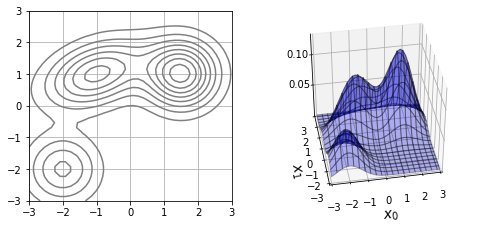

In [16]:
# ------------ 리스트 9-2-(7)
# test -----------------------------------
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array(
    [[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])


Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)


Ax = Fig.add_subplot(1, 2, 2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize=14)
Ax.set_ylabel('$x_1$', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

## 9.3.3 EM 알고리즘의 개요

https://www.youtube.com/watch?v=vmMNQPv4a34&list=PLlSZlNj22M7QAbWnn7ZwRmi4LHjRkg_6c&index=2

EM알고리즘을 사용하여 가우시안 혼합모델을 데이터에 피팅해보고, 부담률 $\gamma$를 구하는 방법을 설명한다
- k-means기법의 확장이다
- EM (expectation-maximization algoritm)
 - 알고리즘 기댓값 최대화 알고리즘은 관측되지 않은 잠재변수에 의존하는 확률 모델에서 최대가능도 혹은 최대사후확룰을 갖는 모수 추정값을 찾는 반복적인 알고리즘이다
 
#### 가우시안 혼합모델의 EM알고리즘

- step 0 : $\pi, \mu, \sigma$ 에 초기값 부여

- step 1 : $\pi, \mu, \sigma$ 로 $\gamma$를 갱신 각 데이터 점은 각 클러스터에서 생성된 사후확률로 $\gamma$를 계산
 - $\gamma$는 한 점이 각각의 클러스터에 속할 확률이 얼마나 되는지
 - $\pi_k$는 각 클러스터의 확률이 어떻게 되는지

- step 2 : $\gamma$로 $\pi, \mu, \sigma$를 갱신 각 클러스터에 대한 부담률로 각 클러스터의 매개변수를 계산

- 수렴할때까지 step 1, step 2 를 반복한다


####  k-means 기법 과  가우시안 혼합모델의 차이
- k-means 기법에서는 각 클러스터를 중심으로 $\mu$를 특정했지만, 가우시안 혼합모델은 중심 벡터 $\mu$와 공분산행렬 $\sigma$를 이용하여 클러스터의 확산정도를 기술한다

- 혼합계수 $\pi$에 의해 각 클러스터의 크기 차이를 설명한다

- 클러스터링의 출력은 k-means기법에서 1-of-k 부호화에서의 R 이었지만, 가우시안 혼합모델은 각 클래스에 속할 확률에 대응하는 부담률 $\gamma$를 출력한다




## 9.3.4 Step 0 : 변수의 준비 및 초기화

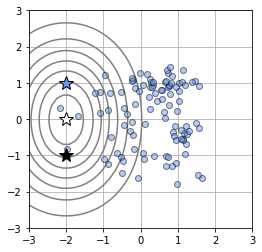

In [17]:
# ----------------- 리스트 9-2-(8)
# 초기 설정 ------------------------------------
N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


X_col=np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])


# 데이터를 그리기 ------------------------------
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma)
    for n in range(N):
        col=gamma[n,0]*X_col[0]+gamma[n,1]*X_col[1]+gamma[n,2]*X_col[2]
        plt.plot(x[n, 0], x[n, 1], 'o',
                 color=tuple(col), markeredgecolor='black',
                 markersize=6, alpha=0.5)
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=tuple(X_col[k]), markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
        
        
    plt.grid(True)


plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

## 9.3.4 Step 1(E Step) : $\gamma$갱신

In [18]:
# ----------------- 리스트 9-2-(9)
# gamma 갱신 (E Step) -------------------
def e_step_mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    gamma = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = pi[k] * y[n, k]
        gamma[n, :] = wk / np.sum(wk)
    return gamma


# 메인 ----------------------------------
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

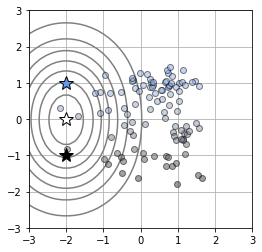

In [19]:
# -------------- 리스트 9-2-(10)
# 표시 ----------------------------------
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

## 9.3.6 Step 2 (M Step) : $\pi, \mu, \sum $의 갱신

In [20]:
# ----------------- 리스트 9-2-(11)
# Pi, Mu, Sigma 갱신 (M step) ------------
def m_step_mixgauss(x, gamma):
    N, D = x.shape
    N, K = gamma.shape
    # pi를 계산
    pi = np.sum(gamma, axis=0) / N
    # mu을 계산
    mu = np.zeros((K, D))
    for k in range(K):
        for d in range(D):
            mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])
    # sigma를 계산
    sigma = np.zeros((K, D, D))
    for k in range(K):
        for n in range(N):
            wk = x - mu[k, :]
            wk = wk[n, :, np.newaxis]
            sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
        sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])
    return pi, mu, sigma


# 메인 ----------------------------------
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

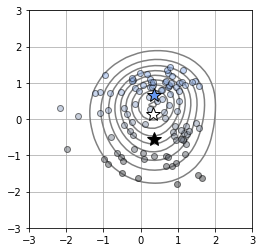

In [21]:
# ----------------- 리스트 9-2-(12)
# 표시 ----------------------------------
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

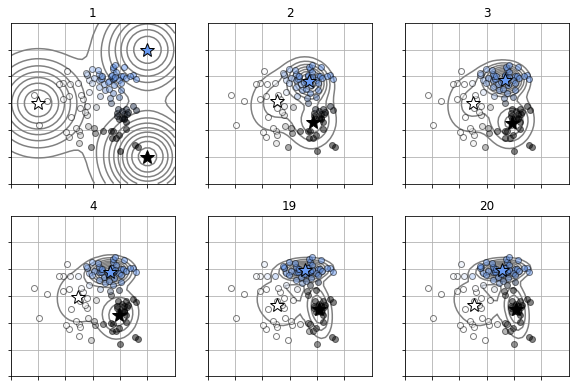

In [22]:
# ----------------- 리스트 9-2-(13)
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize=(10, 6.5))
max_it = 20 # 반복 횟수


i_subplot=1;
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    if it<4 or it>17:
        plt.subplot(2, 3, i_subplot)
        show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
        plt.title("{0:d}".format(it + 1))
        plt.xticks(range(X_range0[0], X_range0[1]), "")
        plt.yticks(range(X_range1[0], X_range1[1]), "")
        i_subplot=i_subplot+1
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)
plt.show()

# _after

분포를 임의의 평균과 분산으로 초기화한다
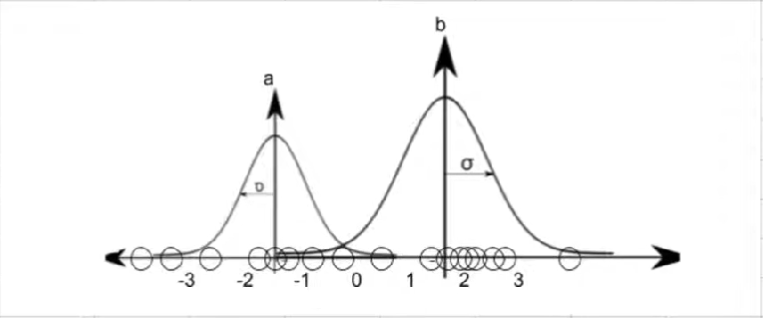

평균과 분산의 정의
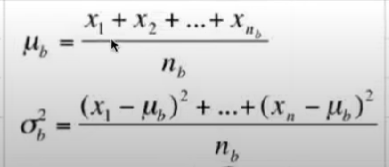
사전확률과 사후확률 정의
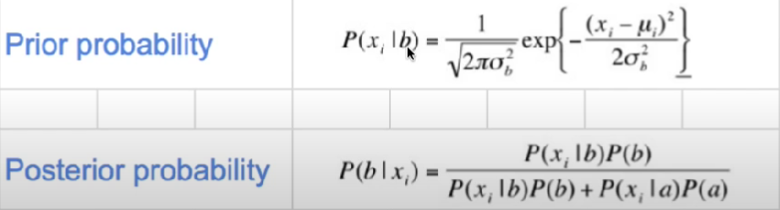
사전확률(정의한 평균과 분산, 실제 평균과 분산 X)을 이용하여 사후확률( 인스턴스가 분포에 속할 확률을 구한다 )
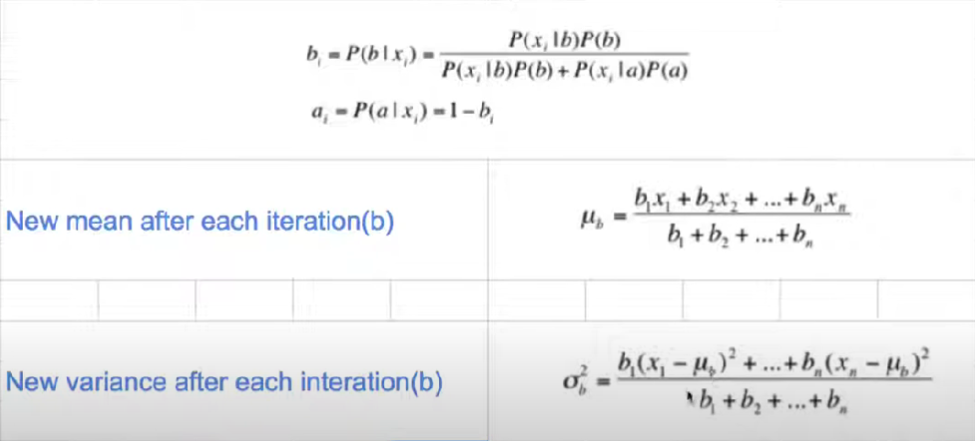
사후 확률을 이용하여 평균과 분산을 업데이트한다
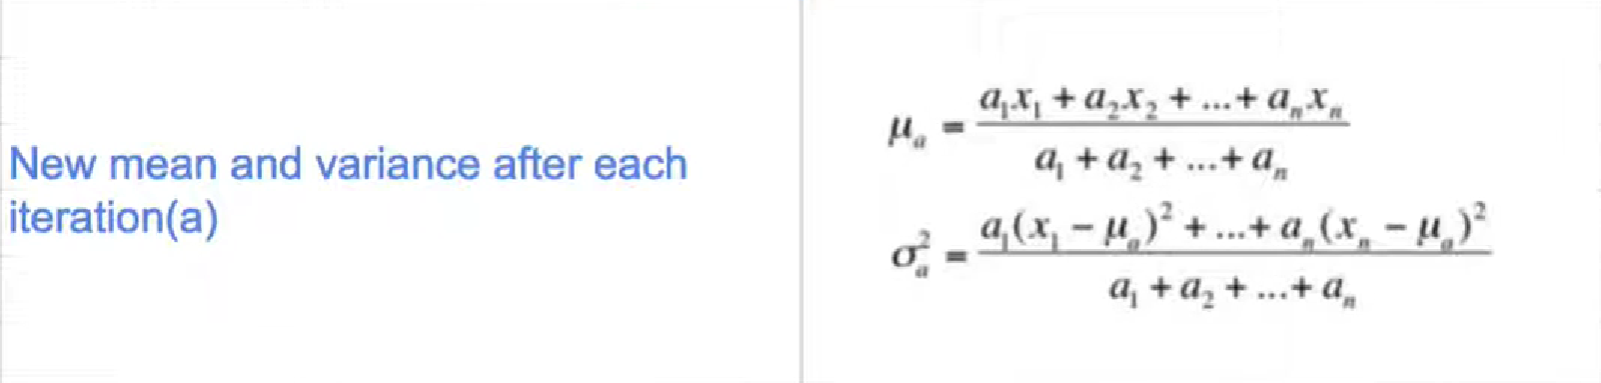

## 9.3.7 가능도

# _after

EM알고리즘이 무엇을 최적화하는지
- EM알고리즘은 가능도 극대화의 원리를 따르고 있다

EM알고리즘의 목적함수는 가능도 이다



In [23]:
# ----------------- 리스트 9-2-(14)
# 혼합 가우스의 목적 함수 ----------------------
def nlh_mixgauss(x, pi, mu, sigma):
    # x: NxD
    # pi: Kx1
    # mu: KxD
    # sigma: KxDxD
    # output lh: NxK
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    lh = 0
    for n in range(N):
        wk = 0
        for k in range(K):
            wk = wk + pi[k] * y[n, k]
        lh = lh + np.log(wk)
    return -lh

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


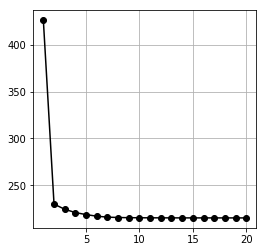

In [24]:
# ----------------- 리스트 9-2-(15)
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


max_it = 20
it = 0
Err = np.zeros(max_it) # distortion measure
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    Err[it] = nlh_mixgauss(X,Pi,Mu,Sigma)
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)


print(np.round(Err, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(np.arange(max_it) + 1,
Err, color='k', linestyle='-', marker='o')
#plt.ylim([40, 80])
plt.grid(True)
plt.show()